In [1]:
from autoencoder import AutoEncoder
import yaml 
from pathlib import Path
from audio_utils import spectrogram2audio
from matplotlib import pyplot as plt
import torch
from IPython.display import Audio
import numpy as np
import librosa
import librosa.display
import numpy as np

In [31]:
path = 'logs/example/version_6'
checkpoint_path = list(Path(path, 'checkpoints').glob('*.ckpt'))[0]

In [32]:
with open(Path(path, 'hparams.yaml')) as file:
    hps = yaml.load(file, Loader=yaml.FullLoader)

In [33]:
ae = AutoEncoder(hps['encoder_layers'], hps['decoder_layers'], checkpoint_path=checkpoint_path)
ae.decoder.eval();

Creates random points interpolation

In [34]:
npoints = 10
frames_per_point = 100

In [50]:
torch.manual_seed(42)
zdim = hps['encoder_layers'][-1]
zs = []
z1 = torch.randn(1, zdim)
for i in range(npoints):
    z2 = torch.randn(1, zdim)
    for t in np.linspace(0,1,frames_per_point):
        zs.append(torch.lerp(z1,z2,t))
    z1 = z2
    z2 = torch.randn(1, zdim)
frames = len(zs)
z = torch.vstack(zs)
with torch.no_grad():
    Y = ae.decoder(z)*hps['Xmax']

In [45]:
torch.rand(Y_.shape).shape

torch.Size([1000, 1025])

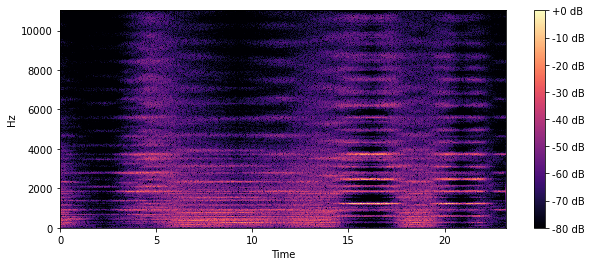

In [46]:
# phase options

phase_option = 'pv'
# phase_option = 'griffinlim'
phase_option = 'random'


fc = 1
hl = hps['hop_length']*fc
wl = hps['win_length']*fc
Y_ = torch.nn.functional.interpolate(Y[:,None,:], (wl//2+1,))[:,0,:]

if phase_option == 'pv':
    griffinlim = False
    phase = torch.rand(Y_.shape[1])*torch.pi*2
    grid = torch.meshgrid(torch.arange(0, frames,dtype=torch.float64), torch.zeros(Y_.shape[1],dtype=torch.float64))[0]
    freqs = torch.linspace(0, hps['target_sampling_rate']//2, wl//2+1)
    dt = hl/hps['target_sampling_rate']
    phase = phase + freqs*2*torch.pi*dt*grid
elif phase_option == 'random':
    griffinlim = False
    phase = (torch.rand(Y_.shape)*2-1)*torch.pi
elif phase_option == 'griffinlim':
    phase = (torch.rand(Y_.shape)*2-1)*torch.pi
    griffinlim = True

audio = spectrogram2audio(Y_,hps['db_min_norm'],phase,hl,wl,hps['spec_in_db'],griffinlim=griffinlim).cpu().numpy()

S = librosa.stft(y=audio, n_fft=hps['win_length'], hop_length=hps['hop_length'])
S_dB = librosa.power_to_db(np.abs(S)**2, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='linear', sr=hps['target_sampling_rate'])
plt.colorbar(format='%+2.0f dB')


Audio(audio,rate=hps['target_sampling_rate'])

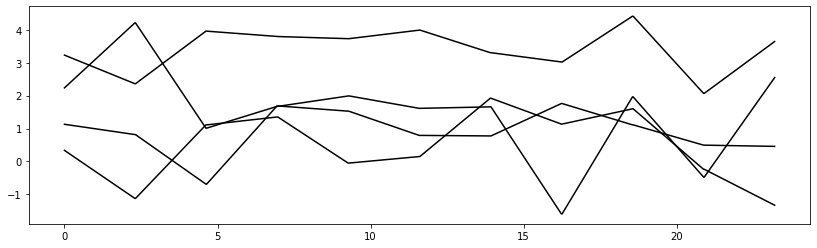

In [51]:
plt.figure(figsize=(14, 4))
Z = z
t = np.arange(0, Z.shape[0])*hl/hps['target_sampling_rate']
plt.plot(t, Z.cpu().numpy() + np.arange(Z.shape[1]) ,color='k')
